In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Import our helper functions
import sys
sys.path.insert(0, './helpers')
from preprocessor import PreProcessor

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load the training data set
df = pd.read_csv('./derived_data/train_data_after_EDA.csv')
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [15]:
for row in df:
    df['compare_sal'] = df.salary > df.salary.shift()

In [16]:
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,compare_sal
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,False
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,False
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,True
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,True
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,True


In [3]:
# List out all the columns we want to be label encoded
cols_to_label = ['companyId','jobType', 'degree', 'major', 'industry']

# Now using this PreProcessor class we will label encode the columns in cols_to_label
label_enc = PreProcessor(cols_to_label)
df = label_enc.fit_transform(df)
df.head()
#df.to_csv('./derived_data/train_final.csv', index=False)

Encoding complete


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,31,1,3,6,3,10,83,130
1,JOB1362684407688,11,0,2,7,6,3,73,101
2,JOB1362684407689,48,7,1,8,3,10,38,137
3,JOB1362684407690,32,5,1,2,0,8,17,142
4,JOB1362684407691,60,7,0,8,2,8,16,163


### Split into Train & Test Set for Model Tuning

In [4]:
# Get a random subset of data for hyperparameter tuning
df_sample = df.sample(frac=0.20, replace=True)

In [5]:
X = df_sample.drop(['jobId', 'salary'], axis=1)
y = df_sample.salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
X_train.shape

(159999, 7)

## Random Forest Baseline Model (1)
This model we fit is without any tuning in order to get an idea what best can we do for tuning to get a better generalized final model.

In [9]:
# Create the baseline 
model_base = RandomForestRegressor(n_estimators=20, oob_score = True, random_state=42)

In [10]:
# Fit and Evaluate the baseline model
model_base = model_base.fit(X_train, y_train)
y_pred = model_base.predict(X_test)

In [11]:
# Calculate Mean Squared Error and OOB (Out-Of-Box) score 
print("The MSE of Base Model is {} and OOB Score is {}".format(MSE(y_test, y_pred), model_base.oob_score_))

The MSE of Base Model is 387.75143963015876 and OOB Score is 0.7198982077310951


## Tuning the Random Forest by hand
### Tune Number of Trees
For the start we will tune number of trees we will need to train our model.

20 trees
OOB Score: 0.7188530836492968
 
40 trees
OOB Score: 0.7403021357089166
 
80 trees
OOB Score: 0.7486812354735466
 
150 trees
OOB Score: 0.7531302803455211
 
200 trees
OOB Score: 0.7540450875777995
 
350 trees
OOB Score: 0.7555722582304055
 
400 trees
OOB Score: 0.755885989401021
 
550 trees
OOB Score: 0.7563849665952446
 
800 trees
OOB Score: 0.7568298883275906
 
1000 trees
OOB Score: 0.756995262845618
 


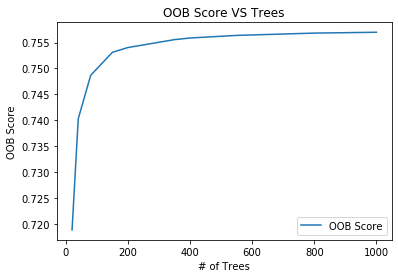

In [21]:
results = []
n_estimator_options = [20, 40, 80, 150, 200, 350, 400, 550, 800, 1000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, n_jobs=-1, oob_score=True, random_state=42)
    model.fit(X_train, y_train)
    print(trees, 'trees')
    OOB = model.oob_score_    #This is basically R2 score
    #y_pred = model_base.predict(X_test)
    #mae = MAE(y_test, y_pred)
    #print('Mean Absolute Error : ', mae)
    print('OOB Score:', OOB)
    results.append(OOB)
    print (" ")
    
plt.plot(n_estimator_options, results, label='OOB Score')
plt.xlabel('# of Trees')
plt.ylabel('OOB Score')
plt.title('OOB Score VS Trees')
plt.legend(loc="lower right")
plt.show()

Adding more number of trees between will give us the best results. If we notice in the graph, after 200 treee there is no significant improvement in the OOB score. Hence, for now with **200 trees** we will tune the next Hyperparameter.

### Tune Max depth of the tree

Max_depth: 2
Mean Absolute Error (Training) :  24.901855074262592
Mean Absolute Error (Test) :  24.937937423689778
 
Max_depth: 3
Mean Absolute Error (Training) :  22.85283099019172
Mean Absolute Error (Test) :  22.936848062427654
 
Max_depth: 4
Mean Absolute Error (Training) :  21.20189780045419
Mean Absolute Error (Test) :  21.265783470784612
 
Max_depth: 5
Mean Absolute Error (Training) :  19.988275106082135
Mean Absolute Error (Test) :  20.053877194032665
 
Max_depth: 6
Mean Absolute Error (Training) :  19.047430278651774
Mean Absolute Error (Test) :  19.13193699733998
 
Max_depth: 7
Mean Absolute Error (Training) :  18.224882713481055
Mean Absolute Error (Test) :  18.339546856464263
 
Max_depth: 8
Mean Absolute Error (Training) :  17.464671642483093
Mean Absolute Error (Test) :  17.60639785266151
 
Max_depth: 9
Mean Absolute Error (Training) :  16.7700106194392
Mean Absolute Error (Test) :  17.020757030780377
 
Max_depth: 10
Mean Absolute Error (Training) :  16.089830983708936
Mea

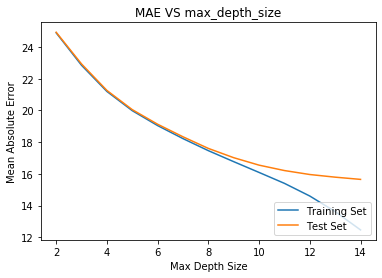

In [12]:
results_train = []
results_test = []
max_depth_size = range(2, 15, 1)

for depth in max_depth_size:
    model = RandomForestRegressor(max_depth=depth, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)
    print('Max_depth:', depth)
    
    y_pred_trn = model.predict(X_train)
    y_pred_tst = model.predict(X_test)
    
    mae_trn = MAE(y_train, y_pred_trn)
    mae_tst = MAE(y_test, y_pred_tst)
    print('Mean Absolute Error (Training) : ', mae_trn)
    print('Mean Absolute Error (Test) : ', mae_tst)
    
    results_train.append(mae_trn)
    results_test.append(mae_tst)
    print (" ")
    
plt.plot(max_depth_size, results_train, label='Training Set')
plt.plot(max_depth_size, results_test, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('Mean Absolute Error')
plt.title('MAE VS max_depth_size')
plt.legend(loc="lower right")
plt.show()

Concluding Max depth between 9-12 is perfect to avoid overfitting. The reason for this is as we increase the depth size, a tree is prone to overfitting in other words the gap between train and test error starts growing. So we can go with a value between 9-12 depth size which will avoid overfitting. 

### Tuning the Max_feature to select the strategy for optimal number of features in each tree

auto option
OOB Score:  0.7496938400726905
 
None option
OOB Score:  0.7496938400726905
 
sqrt option
OOB Score:  0.7570382750682347
 
log2 option
OOB Score:  0.7570382750682347
 
0.7 option
OOB Score:  0.7542836653642881
 
0.2 option
OOB Score:  0.7517895682042839
 


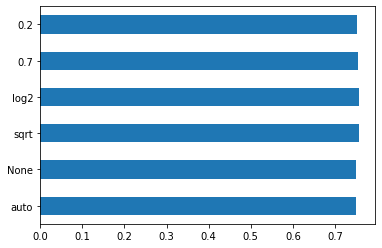

In [20]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.7, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(max_features=max_features, n_estimators = 80,
                                  oob_score=True, n_jobs=-1, random_state=42)
    
    model.fit(X_train, y_train)
    print(max_features, "option")
    OOB = model.oob_score_
    print('OOB Score: ', OOB)
    results.append(OOB)
    print (" ")
    
pd.Series(results, max_features_options).plot(kind='barh')

### Tuning Min Sample Leafs

1 min samples
OOB Score:  0.5791804903694369
 
3 min samples
OOB Score:  0.6058617727199299
 
5 min samples
OOB Score:  0.6176940986727639
 
7 min samples
OOB Score:  0.6226057631593247
 
9 min samples
OOB Score:  0.625960964703411
 
11 min samples
OOB Score:  0.6280118209751315
 
13 min samples
OOB Score:  0.6292660418504824
 
15 min samples
OOB Score:  0.6300629533867638
 
17 min samples
OOB Score:  0.630411217972242
 
19 min samples
OOB Score:  0.6304303618893956
 
21 min samples
OOB Score:  0.6305589625014716
 
23 min samples
OOB Score:  0.6303855278553594
 
25 min samples
OOB Score:  0.6303481454535482
 
27 min samples
OOB Score:  0.6298857981813719
 
29 min samples
OOB Score:  0.6293176717443478
 
31 min samples
OOB Score:  0.6287547496307877
 
33 min samples
OOB Score:  0.6284913465559978
 
35 min samples
OOB Score:  0.6280636437771601
 


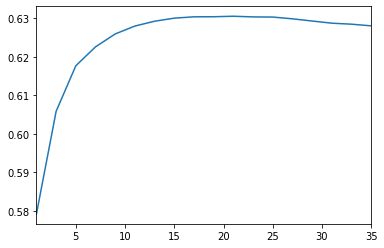

In [15]:
results = []
min_samples_leaf_options = range(1,36, 2)

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(min_samples_leaf=min_samples, 
                                  oob_score=True, n_jobs=-1, random_state=42) 
    
    model.fit(X_train, y_train)
    print(min_samples, "min samples")
    OOB = model.oob_score_
    print('OOB Score: ', OOB)
    results.append(OOB)
    print (" ")
    
pd.Series(results, min_samples_leaf_options).plot()

2 min samples split
OOB Score:  0.5791804903694369
 
8 min samples split
OOB Score:  0.6008545815008705
 
14 min samples split
OOB Score:  0.6128645863724289
 
20 min samples split
OOB Score:  0.6198007042331073
 
26 min samples split
OOB Score:  0.623347065953874
 
32 min samples split
OOB Score:  0.6258377143945408
 
38 min samples split
OOB Score:  0.6274899925044051
 
44 min samples split
OOB Score:  0.6281726077663717
 
50 min samples split
OOB Score:  0.6286131988601049
 
56 min samples split
OOB Score:  0.6286973368657992
 
62 min samples split
OOB Score:  0.6286147203033274
 


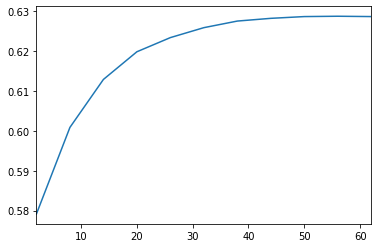

In [28]:
results = []
split_options = range(2,64, 6)

for min_split in split_options:
    model = RandomForestRegressor(min_samples_split=min_split, 
                                  oob_score=True, n_jobs=-1, random_state=42) 
    
    model.fit(X_train, y_train)
    print(min_split, "min samples split")
    OOB = model.oob_score_
    print('OOB Score: ', OOB)
    results.append(OOB)
    print (" ")
    
pd.Series(results, split_options).plot()

### Final Model

In [29]:
X = df.drop(['jobId', 'salary'], axis=1)
y = df.salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [30]:
X_train.shape

(799996, 7)

In [32]:
model = RandomForestRegressor(n_estimators = 300, max_depth=12, max_features='sqrt', min_samples_leaf=15, min_samples_split=26,
                                  oob_score=True, n_jobs=-1, random_state=42)
    
model.fit(X_train, y_train)

y_pred_trn = model.predict(X_train)
y_pred_tst = model.predict(X_test)
    
mse_trn = MSE(y_train, y_pred_trn)
mse_tst = MSE(y_test, y_pred_tst)

print('Mean Squared Error (Training) : ', mse_trn)
print('Mean Squared Error (Test) : ', mse_tst)

Mean Squared Error (Training) :  400.3112523926108
Mean Squared Error (Test) :  410.2968978007859


In [17]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [37]:
model_accuracy = evaluate(model, X_test, y_test)

Model Performance
Average Error: 16.3233 degrees.
Accuracy = 85.07%.


In [39]:
model.oob_score_

0.7253286652531346

In [38]:
base_accuracy = evaluate(model_base, X_test, y_test)

Model Performance
Average Error: 15.0280 degrees.
Accuracy = 86.58%.


In [42]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2,3,5],
    'min_samples_leaf': [2,3,4,6],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [20, 40, 80, 150, 200, 350, 400, 550, 800, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))